In [1]:
!pip install eto
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import bmi_PET
from fao_pet import ETRCalculator
import matplotlib.pyplot as plt
from bmi_cfe import BMI_CFE

In [2]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from bmi_cfe import BMI_CFE

In [3]:
input_dir = './Carmel_inputs_January_2017/config_json_updated'
forcing_dir = './Carmel_inputs_January_2017/forcings'
# output_dir = './output_dir/cfe_output_2017'
output_dir = './Carmel_inputs_January_2017/output_decjanfeb'

In [4]:
# input_dir = './Carmel_inputs_January_2017/pet_config'
# forcing_dir = './Carmel_inputs_January_2017/forcings'
# # output_dir = './output_dir/cfe_output_2017'
# output_dir = './Carmel_inputs_January_2017/output_decjanfeb'

In [5]:
# pip install dataretrieval

In [6]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
# import os
# import json

# def modify_json_key(json_file_path, new_key, filepath, output_directory):
#     with open(json_file_path, 'r') as f:
#         data = json.load(f)

#     # Get the filename without the extension
#     filename_without_extension = os.path.splitext(os.path.basename(json_file_path))[0]
    
#     filename_suffix = filename_without_extension.split("PET_Config_")[-1]
#     # Append the new extension
#     csv_filename = filename_suffix + ".csv"
#     # Set the new key's value to be the filepath + name of the csv file
#     # data[new_key] = [1.0, 0.0]
#     data[new_key] = './Carmel_inputs_January_2017/forcings/'+csv_filename
    
#     #Remove the unit_test key from the json file
#     # if 'unit_test' in data:
#     #     del data['unit_test']

#     # Make sure the output directory exists
#     os.makedirs(output_directory, exist_ok=True)

#     # Construct the output file path
#     output_file_path = os.path.join(output_directory, os.path.basename(json_file_path))

#     # Write the updated dictionary back to the JSON file in the output directory
#     with open(output_file_path, 'w') as f:
#         json.dump(data, f, indent=4)

# def modify_all_json_keys(input_directory, output_directory, new_key):
#     for filename in os.listdir(input_directory):
#         if filename.endswith(".json"):
#             json_file_path = os.path.join(input_directory, filename)
#             modify_json_key(json_file_path, new_key, output_directory, output_directory)

# # use the function
# input_dir = input_dir
# output_dir = './Carmel_inputs_January_2017/pet_config/'
# modify_all_json_keys(input_dir, output_dir, 'csv_file_path')

# 1. Run Normal CFE Simulations

In [8]:
# istart_plot = 0
# iend_plot = 550
# x = list(range(istart_plot, iend_plot))
# for output in outputs:
#     plt.plot(x, output_lists[output][istart_plot:iend_plot], label=output)
#     plt.title(output)
#     plt.legend()
#     plt.show()
#     plt.close()

In [9]:
import os
import json
import pandas as pd

# Check if output directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over all files in input_dir
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):  # check if the file is a JSON file
        file_path = os.path.join(input_dir, filename)
        filename_without_extension = os.path.splitext(os.path.basename(file_path))[0]
        # Initialize CFE instance
        cfe_instance = BMI_CFE(file_path)
        cfe_instance.initialize()
        
        pet_instance = bmi_PET.BMI_pet_model()
        pet_instance.initialize(cfg_file='./Carmel_inputs_January_2017/pet_config/PET_Config_'+filename_without_extension+'.json', current_time_step=1)
        # print(cfg_file)
        pet_instance.update()
        pet_instance.finalize()
        pet = pet_instance.get_value('etr').values

        # Construct forcing file name and read forcing file
        forcing_file_name = filename.replace('.json', '.csv')
        forcing_file_path = os.path.join(forcing_dir, forcing_file_name)
        # print(forcing_file_path)

        with open(forcing_file_path, 'r') as f:
            df_forcing = pd.read_csv(f)

        # Initialize output dictionary
        outputs = cfe_instance.get_output_var_names()
        output_lists = {output:[] for output in outputs}

        # Update CFE instance with each precipitation and PET values
        
        for t, precip in enumerate(df_forcing['APCP_surface']):
            precip = (precip)/1000
            pet[t] = pet[t]/3600
            cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)    
    
            cfe_instance.set_value('water_potential_evaporation_flux', pet[t]*0)
   
            cfe_instance.update()

            for output in outputs:
                output_lists[output].append(cfe_instance.get_value(output))

        cfe_instance.finalize(print_mass_balance=True)

        # Convert output dictionary to DataFrame
        df_output = pd.DataFrame(output_lists)

        # Write output to a CSV file in the output directory
        output_csv_file_path = os.path.join(output_dir, f'{os.path.splitext(filename)[0]}_output.csv')
        df_output.to_csv(output_csv_file_path, index=False)

        # Write output to a JSON file in the output directory
        # output_json_file_path = os.path.join(output_dir, f'{os.path.splitext(filename)[0]}_output.json')
        # with open(output_json_file_path, 'w') as json_file:
        #     json.dump(output_lists, json_file)


GLOBAL MASS BALANCE
  initial volume:   2.1004
    volume input:   0.4777
   volume output:   1.0372
    final volume:   1.5410
        residual: 9.3259e-15

PARTITION MASS BALANCE
    surface runoff:   0.1350
      infiltration:   0.3427
 vol. et from rain:   0.0000
partition residual: -1.1102e-16

GIUH MASS BALANCE
  vol. into giuh:   0.1350
   vol. out giuh:   0.1350
 vol. end giuh q:   0.0000
   giuh residual: 0.0000e+00

SOIL WATER MASS BALANCE
     init soil vol:   0.6166
    vol. into soil:   0.3427
  vol.soil2latflow:   0.6825
   vol. soil to gw:   0.0035
 vol. et from soil:   0.0000
   final vol. soil:   0.2733
  vol. soil resid.: 2.0539e-15

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.6825
  vol. from nash:   0.6729
 final vol. nash:   0.0096
nash casc resid.: -1.4485e-15

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   1.4839
       vol to gw:   0.0035
     vol from gw:   0.2197
final gw.storage:   1.2677
    gw. residual: 5.5511e-

In [10]:
# file = pd.read_csv('./trial_calib/output_calib/cat-3400554_output.csv')
file = pd.read_csv('./Carmel_inputs_January_2017/output_decjanfeb/cat-3400624_output.csv')
discharge = file['land_surface_water__runoff_volume_flux']
giuh = file['GIUH_RUNOFF']
lateral = file['NASH_LATERAL_RUNOFF']
gw = file['DEEP_GW_TO_CHANNEL_FLUX']


In [11]:
file = pd.read_csv('./trial_calib/output_calib/cat-34005541_output.csv')
discharge1 = file['land_surface_water__runoff_depth']
giuh1 = file['GIUH_RUNOFF']
lateral1 = file['NASH_LATERAL_RUNOFF']
gw1 = file['DEEP_GW_TO_CHANNEL_FLUX']

In [12]:
pip install dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [13]:
import dataretrieval.nwis as nwis
import pandas as pd

discharge_nwis = nwis.get_record(sites="11143200", parameterCd='00060', start="2016-12-01", end="2017-02-28")
discharge_resampled = discharge_nwis.select_dtypes(include=['float64', 'int64']).resample('H').mean() # Hourly averaged value
discharge_dataframe = discharge_resampled

In [14]:
discharge_usgs1 = discharge_resampled['00060'].values
discharge_usgs = discharge_usgs1/35.315

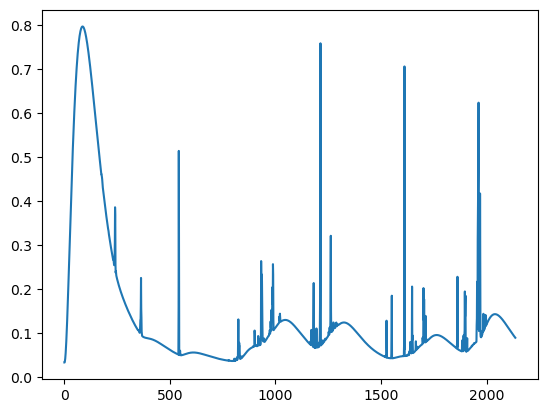

In [15]:
# plt.plot(discharge_usgs)
plt.plot(discharge)
# plt.plot(discharge1)

In [16]:
np.sum(discharge)

293.34574452879286

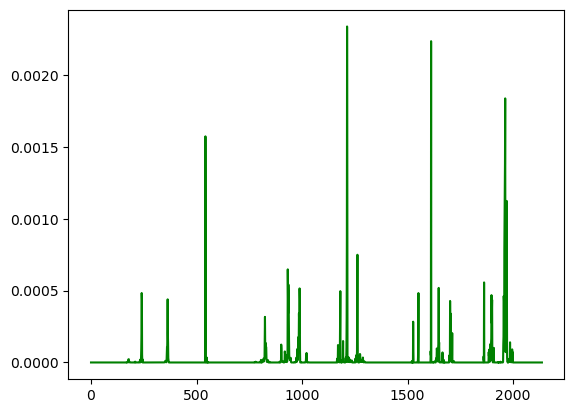

In [17]:
# plt.plot(giuh1, color = 'r')
plt.plot(giuh, color = 'g')

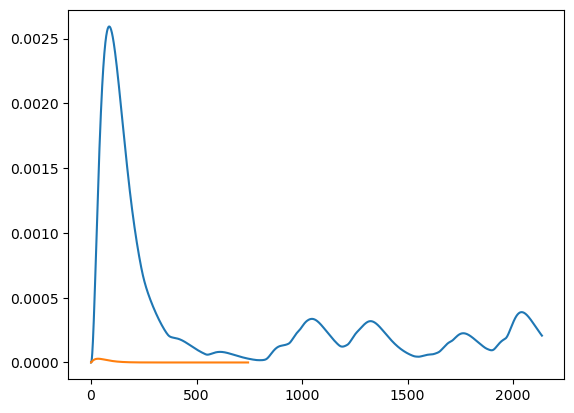

In [18]:
plt.plot(lateral)
plt.plot(lateral1)

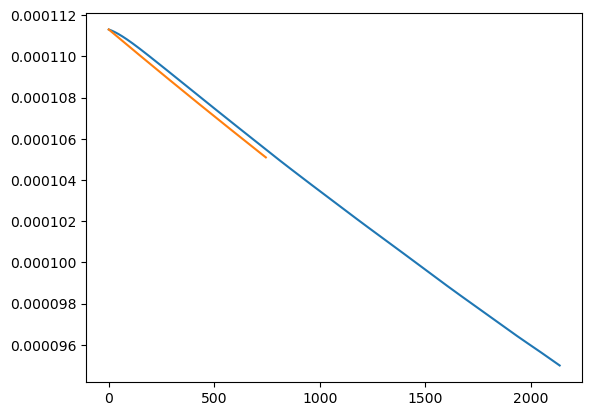

In [19]:
plt.plot(gw)
plt.plot(gw1)